From [speech processing tutorial](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

- ``Mel-Frequency Cepstral Coefficients (MFCCs), filter banks``
- **Steps:**
    * Pre-emphasis filter
    * Sliced into frames and a window is applied to each frame
    * Fourier transform on each frame (Short-Time Fourier Transform) $\Rightarrow$ Calculate the power spectrum
    * Compute **filter banks**
- **For MFCCs**
    * Apply Discrete Cosine Transform (DCT) to the filter banks $\Rightarrow$ Retain a number of the resulting coefficients (discard the rest)
- The final step in both cases: **``mean normalization``**
> **``sample rate``**`` is the number of data point sampled in each second``

In [71]:
import numpy as np
import scipy.io.wavfile
import librosa
import scipy.signal
from scipy.fftpack import dct
import matplotlib.pyplot as plt

In [2]:
audio_pth = './audio/SA1.WAV'

In [3]:
signal, sr = librosa.load(audio_pth)

In [4]:
sr, signal.shape

(22050, (64493,))

In [5]:
duration = signal.shape[0]/sr
print ("Audio duration = %.2f seconds - %.2f" %(duration, librosa.get_duration(signal, sr = sr)))

Audio duration = 2.92 seconds - 2.92


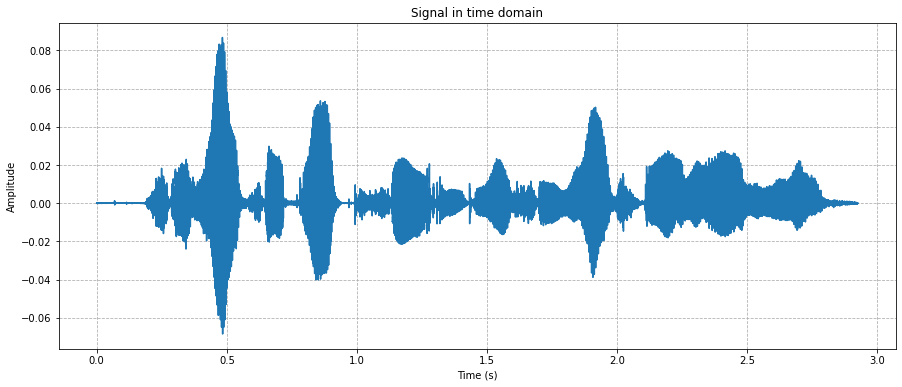

In [15]:
len_ = np.linspace(0, duration, signal.shape[0])
plt.figure(figsize=(15, 6))
plt.plot(len_, signal)
plt.grid(linestyle='dashed')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal in time domain")
plt.show()

## Pre-Emphasis

**Usage of pre-emphasis**
* Balance the frequency spectrum (high frequencies usually have smaller magnitudes compared to lower frequencies)
* Avoid numerical problems during Fourier transform operation
* improve the Signal-to-Noise Ratio (SNR)
$$y(t) = x(t) - \alpha x(t-1)$$
$\alpha$ is pre emphasis value

In [7]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

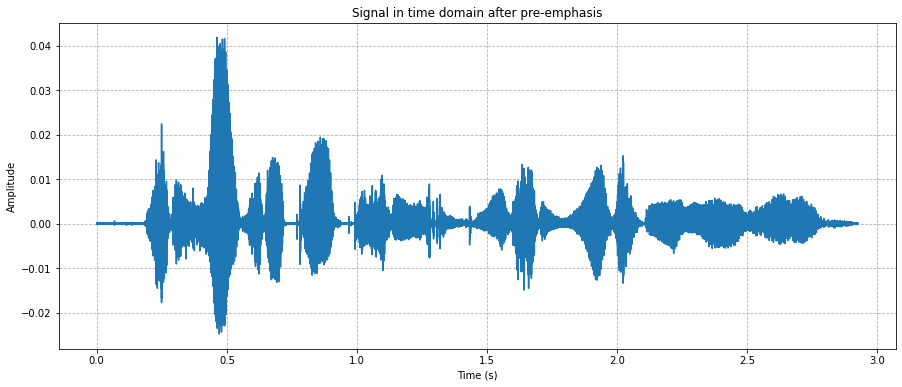

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(len_, emphasized_signal)
plt.grid(linestyle = "dashed")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal in time domain after pre-emphasis")
plt.show()

### Framing
- Split the signal into short-time frames.
- Rationale: frequencies in a signal change over time, so in most cases, it does not make sense to do Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time.
- We can assume that frequencies in a signal are stationary over a short period of time.
- Doing Fourier transform over this short-time frame $\Rightarrow$ obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames

- Typical frame sizes in speech processing range from 20ms to 40ms with 50% (+/-10%) overlap between consecutive frames.
    * Popular frame size: 25ms, stride: 10ms (15ms overlap)

In [23]:
frame_size = 0.025
stride = 0.01
frame_length = int(frame_size * sr)
frame_step = int(stride * sr)

signal_length = int(len(emphasized_signal))

num_frames = int(np.ceil(float(np.abs(signal_length - frame_length))/frame_step))

print (f"Frame length: {frame_length}\nSignal length: {signal_length}\nNum frames: {num_frames}")

Frame length: 551
Signal length: 64493
Num frames: 291


$$num\_frames = \frac{signal\_length - frame\_length}{frame\_step}$$

In [44]:
pad_signal_length = int(num_frames * frame_step + frame_length)
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy = False)]

### Windowing
- After slicing the signal into frames, we apply a window function such as the Hamming Window to each frame. A Hamming window has the following form:
$$w[n] = 0.54 - 0.46\frac{2\pi n}{N-1}$$
where, $0 \leq n \leq N - 1$, N - window length


- **``Reason for using window to frames:``**
    * Counteract the assumption made by the FFT that the data is infinite
    * Reduce spectral leakage

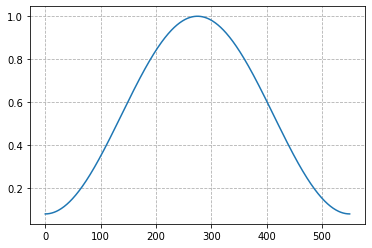

In [65]:
plt.plot(np.hamming(frame_length))
plt.grid(linestyle = "dashed")
plt.show()

In [66]:
frames *= np.hamming(frame_length)

### Fourier transform and power spectrum

- Apply N-point FFT on each frame to calculate the frequency spectrum (Short-Time Fourier Transform - STFT) (N = 256 or 512)
- Power spectrum (periodogram):
$$P = \frac{|FFT(x_i)|^2}{N}$$
where, $x_i$ is the $i^{th}$ frame of the signal $x$.

In [108]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT)) # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * (mag_frames**2)) # power spectrum

In [109]:
mag_frames.shape

(291, 257)

In [110]:
pow_frames.shape

(291, 257)

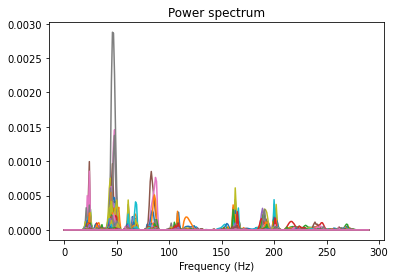

In [112]:
plt.plot(pow_frames)
plt.xlabel("Frequency (Hz)")
plt.title("Power spectrum")
plt.show()

### Filter banks

- The final step to compute filter banks is **``applying triangular filters``**, typically 40 filters (nfilt = 40) on a Mel-scale to the power spectrum to extract frequency bands.
- The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies.
- Convert between Hertz ($f$) and Mel ($m$) using:
$$m = 2595log_{10}\left(1 + \frac{f}{700}\right)$$
$$f = 700(10^{\frac{m}{2595}} - 1)$$
- Each filter in the filter banks is triangular having a response to 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0

$$H_m(k) = \begin{cases}
0, & k < f(m-1)\\
\frac{k - f(m-1)}{f(m) - f(m-1)}, & f(m-1) \leq k \leq f(m)\\
\frac{f(m+1) - k}{f(m+1) - f(m)}, & f(m) \leq k \leq f(m+1)\\
0, & k > f(m+1)
\end{cases}$$

- ``Frequencies are measured by Hertz per second - sample rate: number of sample per second.``

In [132]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sr/2)/700)) # convert Hertz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
hz_points = (700 * (10**(mel_points/2595) - 1)) # convert Mel to Hertz
bin_ = np.floor((NFFT + 1) * hz_points / sr)  # represent f(x) - Hertz

fbank = np.zeros((nfilt, int(np.floor(NFFT/2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin_[m-1])
    f_m = int(bin_[m])
    f_m_plus = int(bin_[m+1])
    
    for k in range(f_m_minus, f_m):
        fbank[m-1, k] = (k - bin_[m-1])/(bin_[m] - bin_[m-1])
    for k in range(f_m, f_m_plus):
        fbank[m-1, k] = (bin_[m+1] - k)/(bin_[m+1] - bin_[m])
        
filter_banks = np.dot(pow_frames, fbank.T) # apply filters to power spectrum
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks= 20 * np.log10(filter_banks)

In [158]:
mel_points

array([   0.        ,   77.47118135,  154.94236271,  232.41354406,
        309.88472542,  387.35590677,  464.82708812,  542.29826948,
        619.76945083,  697.24063219,  774.71181354,  852.18299489,
        929.65417625, 1007.1253576 , 1084.59653896, 1162.06772031,
       1239.53890166, 1317.01008302, 1394.48126437, 1471.95244573,
       1549.42362708, 1626.89480843, 1704.36598979, 1781.83717114,
       1859.3083525 , 1936.77953385, 2014.2507152 , 2091.72189656,
       2169.19307791, 2246.66425926, 2324.13544062, 2401.60662197,
       2479.07780333, 2556.54898468, 2634.02016603, 2711.49134739,
       2788.96252874, 2866.4337101 , 2943.90489145, 3021.3760728 ,
       3098.84725416, 3176.31843551])

In [133]:
filter_banks.shape

(291, 40)

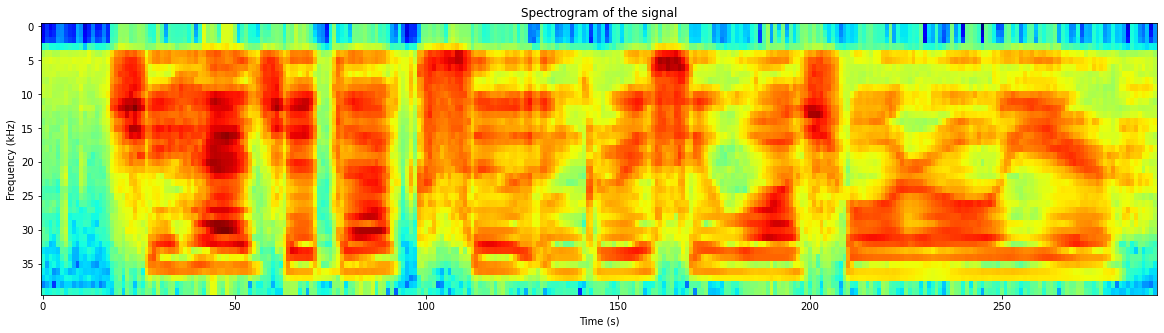

In [200]:
plt.figure(figsize = (20, 5))
plt.imshow(filter_banks.T[::-1, :], aspect='auto', cmap = 'jet')
plt.title("Spectrogram of the signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (kHz)")
plt.show()

In [138]:
fbank.shape

(40, 257)

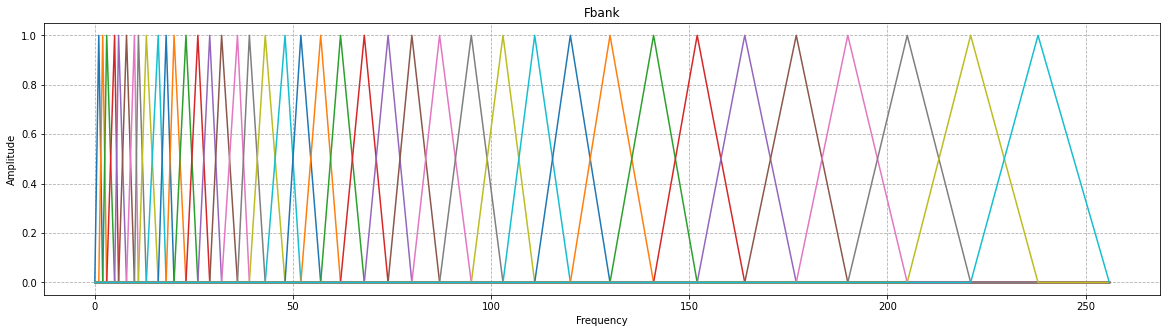

In [142]:
plt.figure(figsize=(20, 5))
for i in range(fbank.shape[0]):
    plt.plot(fbank[i, :])

plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Fbank")
plt.grid(linestyle="dashed")
plt.show()

### Mel-frequency Cepstral Coefficients (MFCCs)

- Filter bank coefficients computed in the last step are highly correlated. <br>
$\Rightarrow$ Apply Discrete Cosine Transform (DCT) to **decorrelate** the filter bank coefficients and yeild a compressed representation of the filter banks.
- The resulting cepstral coefficients 2-13 are retained and the rest are discarded (for ASR problems). *The reason is that they represent fast changes in the filter bank coefficients and these fine details do not contribute to Automatic Speech Recognition (ASR).*
- ``Sinusoidal liftering can be used to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals. (1)`` <br>
> (1) Liftering is filtering in the cepstral domain. Note the abuse of notation in spectral and cepstral with filtering and liftering respectively.

In [160]:
num_ceps = 12
mfcc = dct(filter_banks, type = 2, axis = 1, norm = 'ortho')[:, 1 : num_ceps + 1]

In [161]:
mfcc.shape

(291, 12)

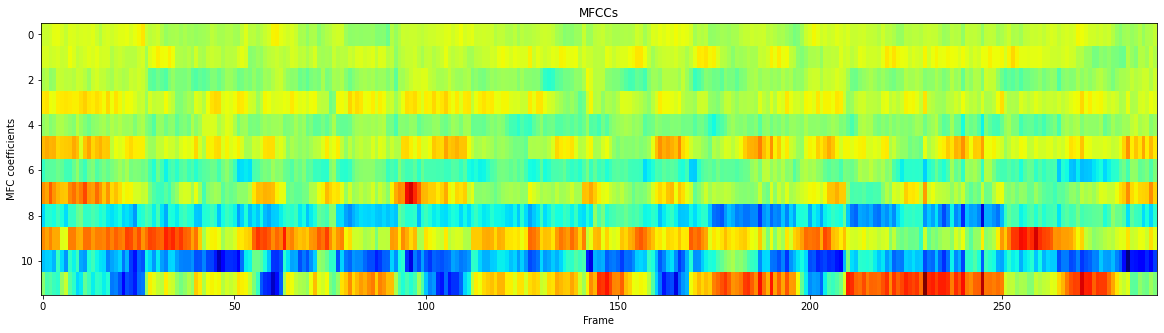

In [199]:
plt.figure(figsize=(20, 5))
plt.imshow(mfcc.T[::-1, :], aspect='auto', cmap = 'jet')
plt.title("MFCCs")
plt.xlabel("Frame")
plt.ylabel("MFC coefficients")
plt.xticks()
plt.show()

### Mean normalization

- **``Subtract mean of each coefficient from all frames``**

In [202]:
filter_banks -= (np.mean(filter_banks, axis = 0) + 1e-8)
mfcc -= (np.mean(mfcc, axis = 0) + 1e-8)

``The filter banks is represented by a matrix (frame x frequency). Each point in the matrix show the Amplitude in dB of the signal``

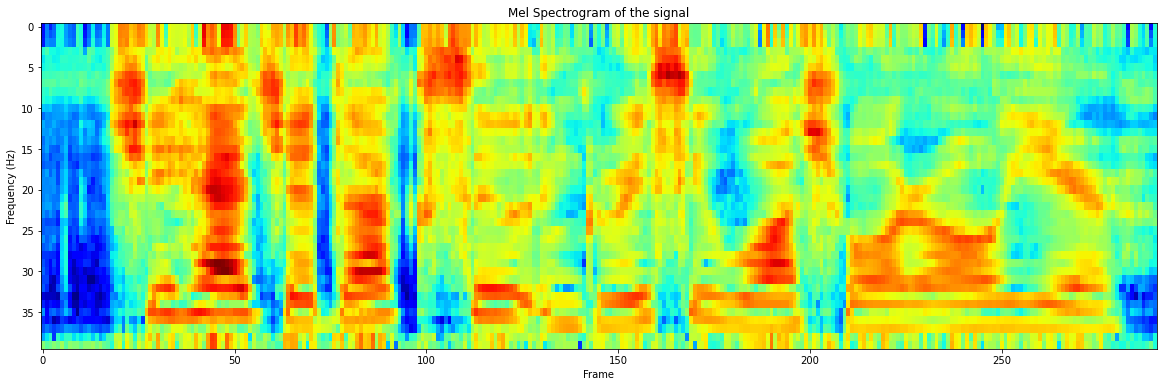

In [203]:
plt.figure(figsize=(20, 6))
plt.imshow(filter_banks.T[::-1, :], aspect='auto', cmap='jet')
plt.title("Mel Spectrogram of the signal")
plt.xlabel("Frame")
plt.ylabel("Frequency (Hz)")
plt.show()

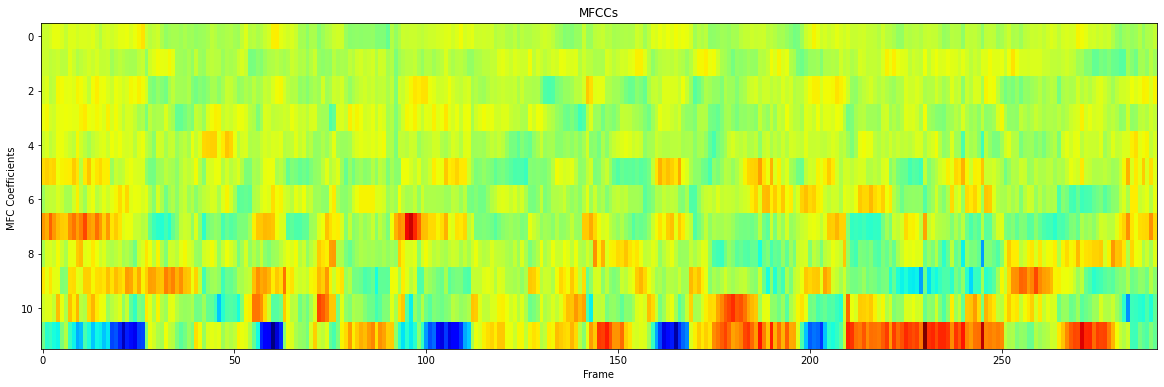

In [204]:
plt.figure(figsize=(20, 6))
plt.imshow(mfcc.T[::-1, :], aspect='auto', cmap='jet')
plt.title("MFCCs")
plt.xlabel("Frame")
plt.ylabel("MFC Coefficients ")
plt.show()

In [239]:
spectrum = librosa.magphase(librosa.stft(signal, n_fft=512))[0]
spectrograms = librosa.feature.melspectrogram(S = spectrum, win_length=frame_length)
mel_sgram = librosa.amplitude_to_db(spectrograms, ref = np.min)

In [240]:
mel_sgram.shape

(128, 504)

In [241]:
import librosa.display

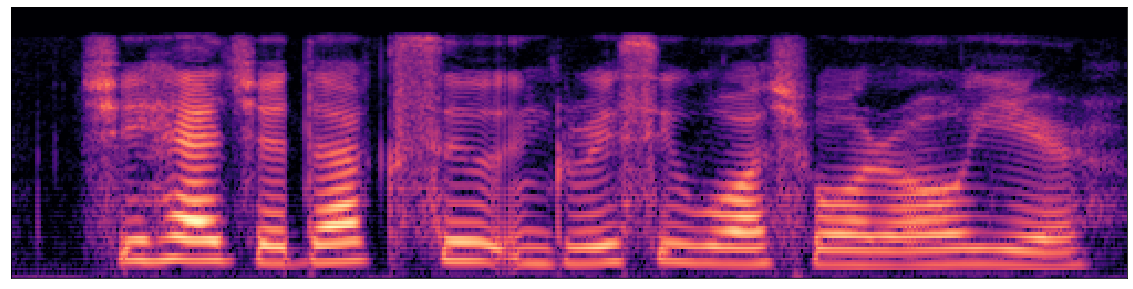

In [249]:
plt.figure(figsize=(20, 5))
cmap=plt.get_cmap('plasma')
librosa.display.specshow(mel_sgram)
plt.show()